<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_TimestampPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HAC Data Preprocessing

### Import Libraries

In [ ]:
# Import Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Set up global settings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [ ]:
# Data Collection
def setup_google_drive():
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)


def download_file(drive, file_id, file_name):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)


def collect_data():
    drive = setup_google_drive()

    # List of files and their IDs
    files_to_download = {
        'D_LABITEMS.csv': '1YsUqF-NkdLUL2hWRaxQgE7pyB1lGv4ox',
        'D_ICD_PROCEDURES.csv': '10nZG-naIdrVd1wj7JI5cwYDx4a8sp738',
        'D_ITEMS.csv': '11Jy050RqqIRPnsgbM6-YSRILyvIKRxJk',
        'D_ICD_DIAGNOSES.csv': '1d8oxIZy-UY1AflEgmYugfTFHKn9tiK_P',
        'PATIENTS.csv': '1JI_F9GBr7ul5c-c4C1x0xxcfOB3BOTxv',
        'PROCEDURES_ICD.csv': '1eWYJMBcujAlKohuDyl99obl9wZzaveu4',
        'ADMISSIONS.csv': '1zfjctJQU-FtY-EOoUh_f4_bSVrPOn0Kc',
        'DIAGNOSES_ICD.csv': '1O_5wyg0LHDnlKq8ULLyVG0hC862fqoJb',
        'LABEVENTS.csv': '1zAIm6nbkWrAtHNu06J34ygsPavYtpCjR',
        'PROCEDUREEVENTS_MV.csv': '1zFCSDwZDo9JyUfyhO9yt44KWBMXXC1Jy'
    }

    for file_name, file_id in files_to_download.items():
        download_file(drive, file_id, file_name)

    return {
        'd_labitems': pd.read_csv('D_LABITEMS.csv'),
        'd_icd_procedures': pd.read_csv('D_ICD_PROCEDURES.csv'),
        'd_items' : pd.read_csv('D_ITEMS.csv'),
        'd_icd_diagnoses' : pd.read_csv('D_ICD_DIAGNOSES.csv'),
        'patients' : pd.read_csv('PATIENTS.csv'),
        'procedures_icd' : pd.read_csv('PROCEDURES_ICD.csv'),
        'admissions' : pd.read_csv('ADMISSIONS.csv'),
        'diagnoses_icd' : pd.read_csv('DIAGNOSES_ICD.csv'),
        'labevents' : pd.read_csv('LABEVENTS.csv', usecols=['HADM_ID', 'ITEMID', 'FLAG', 'CHARTTIME']),
        'procedureevents_mv' : pd.read_csv('PROCEDUREEVENTS_MV.csv', usecols=['HADM_ID', 'ITEMID', 'STARTTIME'])
    }


### Create Functions for Data Preprocessing

In [ ]:
# Data Cleaning
def add_admission_duration(admissions):
    admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
    admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
    admissions['admission_duration'] = admissions['DISCHTIME'] - admissions['ADMITTIME']
    return admissions

def merge_patients_admission(admissions, patients):
    return pd.merge(admissions, patients, on='SUBJECT_ID', how='left')

def calculate_and_set_age(admission_merged):
    # Convert columns to datetime format
    admission_merged['ADMITTIME'] = pd.to_datetime(admission_merged['ADMITTIME'])
    admission_merged['DOB'] = pd.to_datetime(admission_merged['DOB'])

    # Calculate age using the 'calculate_age' function
    admission_merged['AGE_AT_ADMISSION'] = admission_merged.apply(
        lambda row: calculate_age(row['ADMITTIME'], row['DOB']),
        axis=1
    )
    return admission_merged

def calculate_age(admit_time, dob):
    try:
        # Convert pandas timestamps to Python datetime objects
        admit_datetime = admit_time.to_pydatetime()
        dob_datetime = dob.to_pydatetime()

        # Calculate age
        age = int((admit_datetime - dob_datetime).days // 365.25)
        return age if age > 0 else np.nan  # Assign NaN for negative ages
    except OverflowError:
        return np.nan

def replace_invalid_ages(admission_merged):
    # Compute the median age
    median_age = admission_merged['AGE_AT_ADMISSION'].median()

    # Replace values greater than 100 with the median age
    admission_merged.loc[admission_merged['AGE_AT_ADMISSION'] > 130, 'AGE_AT_ADMISSION'] = median_age

    # Convert timedelta to days
    admission_merged['admission_duration_days'] = admission_merged['admission_duration'].dt.total_seconds() / (24 * 3600)

    return admission_merged

def merge_diagnosis_names(diagnoses_icd, d_icd_diagnoses):
    # Convert the ICD9_CODE columns in both DataFrames to string data type
    d_icd_diagnoses['ICD9_CODE'] = d_icd_diagnoses['ICD9_CODE'].astype(str)
    diagnoses_icd['ICD9_CODE'] = diagnoses_icd['ICD9_CODE'].astype(str)

    # Merge diagnosis with diagnosis_icd using a left merge
    diagnosis_merged = pd.merge(diagnoses_icd, d_icd_diagnoses, on='ICD9_CODE', how='left')

    return diagnosis_merged

def combine_procedures(d_icd_procedures):
    # Combine the descriptions for the same ICD code
    d_icd_procedures['SHORT_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['SHORT_TITLE'].transform(lambda x: ' | '.join(x))
    d_icd_procedures['LONG_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['LONG_TITLE'].transform(lambda x: ' | '.join(x))

    # Drop duplicated rows based on ICD9_CODE, keeping the first occurrence
    procedure_icd_cleaned = d_icd_procedures.drop_duplicates(subset='ICD9_CODE', keep='first')

    return procedure_icd_cleaned

def merge_procedure_names(procedures_icd, procedure_icd_cleaned):
    # Copy the DataFrame to avoid modifying the original data
    procedure_icd_cleaned = procedure_icd_cleaned.copy()

    # Convert the ICD9_CODE columns to string data type
    procedure_icd_cleaned['ICD9_CODE'] = procedure_icd_cleaned['ICD9_CODE'].astype(str)
    procedures_icd['ICD9_CODE'] = procedures_icd['ICD9_CODE'].astype(str)

    # Merge procedure with procedure_icd using a left merge
    procedure_merged = pd.merge(procedures_icd, procedure_icd_cleaned, on='ICD9_CODE', how='left')

    return procedure_merged

def merge_lab_events(labevents, d_labitems):
    # Merge lab_event with lab_item using a left merge
    lab_merged = pd.merge(labevents, d_labitems, on='ITEMID', how='left')

    return lab_merged

def clean_admission_merged(admission_merged):
    # Drop irrelevant columns
    columns_to_drop = ['ROW_ID_x', 'ROW_ID_y', 'DISCHARGE_LOCATION']
    admission_merged = admission_merged.drop(columns=columns_to_drop)

    return admission_merged

def clean_diagnosis_merged(diagnosis_merged):
    # Drop irrelevant columns
    columns_to_drop = ['ROW_ID_x', 'ROW_ID_y', 'SUBJECT_ID']
    diagnosis_merged = diagnosis_merged.drop(columns=columns_to_drop)

    return diagnosis_merged

def sample_balanced_dataset(diagnosis_merged, admission_merged, size=5000, use_all_data=False):
    # Extract unique HADM_IDs where the diagnosis is UTI (ICD9_CODE = '5990')
    uti_hadm_ids = diagnosis_merged[diagnosis_merged['ICD9_CODE'] == '5990']['HADM_ID'].unique()

    if use_all_data:
        sampled_uti_hadm_ids = uti_hadm_ids  # Use all the available HADM_IDs for UTI
    else:
        # Randomly sample 'size' number of unique HADM_IDs from UTI cases
        sampled_uti_hadm_ids = np.random.choice(uti_hadm_ids, size=size, replace=False)

    # Get unique HADM_IDs for non-UTI cases
    non_uti_hadm_ids = diagnosis_merged[diagnosis_merged['ICD9_CODE'] != '5990']['HADM_ID'].unique()

    if use_all_data:
        sampled_non_uti_hadm_ids = non_uti_hadm_ids  # Use all the available HADM_IDs for non-UTI
    else:
         # Randomly sample 'size' number of unique HADM_IDs from non-UTI cases
        sampled_non_uti_hadm_ids = np.random.choice(non_uti_hadm_ids, size=size, replace=False)

    # Filter rows from diagnosis_merged where HADM_ID is in sampled_uti_hadm_ids and ICD9_CODE is '5990'
    sampled_uti_diagnosis = diagnosis_merged[(diagnosis_merged['HADM_ID'].isin(sampled_uti_hadm_ids)) & (diagnosis_merged['ICD9_CODE'] == '5990')]

    # Drop duplicates based on HADM_ID and ICD9_CODE
    sampled_uti_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)

    # Filter rows from diagnosis_merged where HADM_ID is in sampled_non_uti_hadm_ids
    sampled_non_uti_diagnosis = diagnosis_merged[diagnosis_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)]

    # Combine UTI and non-UTI samples in both dataframes
    final_sampled_diagnosis = pd.concat([sampled_uti_diagnosis, sampled_non_uti_diagnosis]).reset_index(drop=True)

    # Combine sampled admission information
    sampled_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_uti_hadm_ids)]
    sampled_non_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)]
    final_sampled_admission = pd.concat([sampled_uti_admission, sampled_non_uti_admission]).reset_index(drop=True)

    return final_sampled_diagnosis, final_sampled_admission


def preprocess_diagnosis_admission(final_sampled_diagnosis, final_sampled_admission):
    # Filter the rows where the diagnosis is UTI (ICD9_CODE = '5990')
    final_sampled_diagnosis = final_sampled_diagnosis[final_sampled_diagnosis['ICD9_CODE'] == '5990']

    # Drop duplicate rows based on HADM_ID and ICD9_CODE
    final_sampled_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)

    # Add a column to indicate the presence of the diagnosis (UTI in this case)
    final_sampled_diagnosis['present'] = 1

    # Pivot the dataframe to make it wide-format. This sets HADM_ID as index and ICD9_CODEs as columns
    wide_diagnosis = final_sampled_diagnosis.pivot(index=['HADM_ID'], columns='ICD9_CODE', values='present').fillna(0).reset_index()

    # Merge with the sampled admission data
    admission_icd_merged = pd.merge(final_sampled_admission, wide_diagnosis, on=['HADM_ID'], how='left')

    # Identify the ICD9_CODE columns and fill NaN values with 0
    icd9_columns = wide_diagnosis.columns.difference(['HADM_ID'])
    admission_icd_merged[icd9_columns] = admission_icd_merged[icd9_columns].fillna(0)

    # Rename the '5990' column to 'uti' for easier interpretation
    admission_icd_merged = admission_icd_merged.rename(columns={'5990': 'uti'})

    ## For categorical variable, replace NaN with 'missing_value'.
    admission_icd_merged['LANGUAGE'].fillna('missing_value', inplace=True)
    admission_icd_merged['MARITAL_STATUS'].fillna('missing_value', inplace=True)

    # For the AGE_AT_ADMISSION column, replace NaN values with the median.
    median_age = admission_icd_merged['AGE_AT_ADMISSION'].median()
    admission_icd_merged['AGE_AT_ADMISSION'].fillna(median_age, inplace=True)

    # drop unwanted columns
    admission_icd_merged.drop(columns=['DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME',
                                       'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'admission_duration',
                                       'INSURANCE', 'LANGUAGE', 'RELIGION',
                                       'HOSPITAL_EXPIRE_FLAG', 'EXPIRE_FLAG', 'MARITAL_STATUS',
                                       'admission_duration_days'], inplace=True)
    return admission_icd_merged


# Preprocess lab_merged
def preprocess_lab(lab_merged):
    lab_subset = lab_merged[["HADM_ID", "LABEL", "FLAG", "CHARTTIME"]]
    lab_subset = lab_subset[lab_subset["FLAG"] == "abnormal"]

    lab_subset = lab_subset[["HADM_ID", "LABEL", "CHARTTIME"]]
    lab_subset.columns = ["HADM_ID", "lab_flag", "CHARTTIME"]

    lab_subset['present'] = 1
    wide_lab = lab_subset.pivot_table(index=['HADM_ID', 'CHARTTIME'], columns='lab_flag', values='present', aggfunc='first').reset_index()

    lab_columns = wide_lab.columns.difference(['HADM_ID', 'CHARTTIME'])
    wide_lab[lab_columns] = wide_lab[lab_columns].fillna(0)

    return wide_lab


# TO CHECK: preprocess procedures with topic modelling
def preprocess_procedure2(procedure_merged, procedureevents_mv, n_groups=40):
    # extract rows with nans as long title, will use for later
    proced_icd_nans = procedure_merged[procedure_merged['LONG_TITLE'].isnull()]
    # drop rows with nans as long title
    proced = procedure_merged[procedure_merged['LONG_TITLE'].notnull()]
    list_procedures = proced['LONG_TITLE'].unique()

    # topic modelling for dimensionality reduction
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(list_procedures)

    # LDA
    lda = LatentDirichletAllocation(n_components=n_groups, random_state=42)
    lda_fit = lda.fit_transform(X)

    topic_list = []
    for i in range(len(lda_fit)):
        topic_list.append(np.argmax(lda_fit[i]))

    # map the topic to the procedure
    topic_proced = pd.DataFrame({'topic':topic_list, 'procedure':list_procedures})
    proced['topic'] = proced['LONG_TITLE'].map(topic_proced.set_index('procedure')['topic'])

    # Extract First Timestamp for Each Admission
    first_procedure_times = procedureevents_mv.groupby('HADM_ID').agg({'STARTTIME': 'min'}).reset_index()

    # Merge with Procedures Data on HADM_ID to associate each procedure with the earliest STARTTIME.
    proced = pd.merge(proced, first_procedure_times, on='HADM_ID', how='left')

    # reduce the df down to only the columns we need
    proced_icd_topic = proced[['HADM_ID', 'topic', 'STARTTIME']]
    proced_n = proced_icd_topic.pivot_table(index=['HADM_ID', 'STARTTIME'], columns='topic', aggfunc=len, fill_value=0)
    proced_n.reset_index(inplace=True)

    # reconstruct the df with the nans
    proced_icd_nans2 = proced_icd_nans[['HADM_ID']]
    proced_icd_nans2['topic'] = n_groups
    proced_icd_nans2 = proced_icd_nans2.pivot_table(index=['HADM_ID'], columns='topic', aggfunc=len, fill_value=0)
    proced_icd_nans2.reset_index(inplace=True)

    # merge the two dfs
    proced_n = proced_n.merge(proced_icd_nans2, on=['HADM_ID'], how='outer')
    proced_n.fillna(0, inplace=True)
    cols_to_convert = [col for col in proced_n.columns if col not in ['HADM_ID', 'STARTTIME']]
    proced_n[cols_to_convert] = proced_n[cols_to_convert].astype(int)

    # add prefix to column names
    proced_n = proced_n.add_prefix('p_')
    proced_n.rename(columns={'p_HADM_ID': 'HADM_ID', 'p_STARTTIME': 'STARTTIME'}, inplace=True)
    proced_n = proced_n.rename_axis(None, axis=1)
    return proced_n, lda, vectorizer


def proced_feature_names(df, lda, vectorizer):
    # just for checking
    feature_names = vectorizer.get_feature_names_out()
    n_top_words = 10
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[::-1][:n_top_words] # get the index, sort by highest of the top words for each topic
        top_words = [feature_names[i] for i in top_words_idx] # map the index to the word
        #print(f"Topic {topic_idx}:", top_words)

    topic = {
        'p_0': 'Procedure: Digestive and Diaphragm Procedures',
        'p_1': 'Procedure: Lung Biopsy and Intervention',
        'p_2': 'Procedure: Cardiac Repair and Hernia Procedures',
        'p_3': 'Procedure: Intestinal Stoma and Manipulation',
        'p_4': 'Procedure: Aspiration and Organ Repair',
        'p_5': 'Procedure: Head and Device Insertion',
        'p_6': 'Procedure: Surgical Suture and Repair',
        'p_7': 'Procedure: Bone Fracture and Fixation',
        'p_8': 'Procedure: Electrode and Vascular Implantation',
        'p_9': 'Procedure: Structural and Bone Biopsy',
        'p_10': 'Procedure: Intestinal Transfer and Surgery',
        'p_11': 'Procedure: Gastric Procedure and Vascular Revision',
        'p_12': 'Procedure: Tissue Reconstruction and Catheterization',
        'p_13': 'Procedure: Arterial Imaging and Debridement',
        'p_14': 'Procedure: Limb Exploration and Surgery',
        'p_15': 'Procedure: Hip and Soft Tissue Procedures',
        'p_16': 'Procedure: Diagnostic and Device Implantation',
        'p_17': 'Procedure: Closure and Chest Procedures',
        'p_18': 'Procedure: Thoracic and Peritoneal Interventions',
        'p_19': 'Procedure: Trachea and Abdominal Procedures',
        'p_20': 'Procedure: Endoscopic and Perineal Procedures',
        'p_21': 'Procedure: Pancreatic and Bronchial Interventions',
        'p_22': 'Procedure: Dilation and Urethral Procedures',
        'p_23': 'Procedure: Spinal and Abdominal Surgery',
        'p_24': 'Procedure: Catheterization and Ventilation Techniques',
        'p_25': 'Procedure: Joint Dislocation and Hand Surgery',
        'p_26': 'Procedure: Vessel Anastomosis and Resection',
        'p_27': 'Procedure: Lesion Excision and Soft Tissue Surgery',
        'p_28': 'Procedure: External Device and Eyelid Repair',
        'p_29': 'Procedure: Tendon and Obstetric Procedures',
        'p_30': 'Procedure: Cranial and Peripheral Interventions',
        'p_31': 'Procedure: Large Intestine and Bone Surgery',
        'p_32': 'Procedure: Plastic Surgery and Duct Procedures',
        'p_33': 'Procedure: Foreign Body Removal and Graft',
        'p_34': 'Procedure: Facial and Thoracic Surgery',
        'p_35': 'Procedure: Knee and Spinal Surgery',
        'p_36': 'Procedure: Contrast Imaging and Spleen Procedures',
        'p_37': 'Procedure: Injections and Therapeutic Procedures',
        'p_38': 'Procedure: Fibula and Sinus Procedures',
        'p_39': 'Procedure: Renal and Thyroid Interventions',
        'p_40': 'Procedure: Not Found'
        }

    df.rename(columns=topic, inplace=True)
    return df

def one_hot_encoding(df):
    return pd.get_dummies(df, columns=None, drop_first=False)

### Run the Main Pipeline

In [ ]:
# Main Pipeline
def main():
    # Collect data
    data = collect_data()

    # Perform Data Cleaning
    data['admissions'] = add_admission_duration(data['admissions'])
    admission_merged = merge_patients_admission(data['admissions'], data['patients'])
    admission_merged = calculate_and_set_age(admission_merged)
    admission_merged = replace_invalid_ages(admission_merged)
    diagnosis_merged = merge_diagnosis_names(data['diagnoses_icd'], data['d_icd_diagnoses'])
    procedure_icd_cleaned = combine_procedures(data['d_icd_procedures'])
    procedure_merged = merge_procedure_names(data['procedures_icd'], procedure_icd_cleaned)
    lab_merged = merge_lab_events(data['labevents'], data['d_labitems'])
    admission_merged = clean_admission_merged(admission_merged)
    diagnosis_merged = clean_diagnosis_merged(diagnosis_merged)
    procedureevents_mv = data['procedureevents_mv']

    # Sample dataset
    np.random.seed(123)
    final_sampled_diagnosis, final_sampled_admission = sample_balanced_dataset(diagnosis_merged, admission_merged, size=5000, use_all_data=False)

    # Preprocess diagnosis
    admission_icd_merged = preprocess_diagnosis_admission(final_sampled_diagnosis, final_sampled_admission)

    # Preprocess lab
    wide_lab = preprocess_lab(lab_merged)

    # Preprocess procedure
    proced_n, lda, vectorizer = preprocess_procedure2(procedure_merged, procedureevents_mv)
    wide_procedure = proced_feature_names(proced_n, lda,  vectorizer)

    # Rename time columns to a consistent name 'TIMESTAMP'
    admission_icd_merged.rename(columns={'ADMITTIME': 'TIMESTAMP'}, inplace=True)
    wide_procedure.rename(columns={'STARTTIME': 'TIMESTAMP'}, inplace=True)
    wide_lab.rename(columns={'CHARTTIME': 'TIMESTAMP'}, inplace=True)

    # Ensure that TIMESTAMP columns are in datetime format before merging
    admission_icd_merged['TIMESTAMP'] = pd.to_datetime(admission_icd_merged['TIMESTAMP'])
    wide_procedure['TIMESTAMP'] = pd.to_datetime(wide_procedure['TIMESTAMP'])
    wide_lab['TIMESTAMP'] = pd.to_datetime(wide_lab['TIMESTAMP'])


    # Merge datasets using both 'HADM_ID' and 'TIMESTAMP'
    admission_icd_procedure_merged = pd.merge(admission_icd_merged, wide_procedure, on=['HADM_ID'], how='left')
    admission_icd_procedure_lab_merged = pd.merge(admission_icd_procedure_merged, wide_lab, on=['HADM_ID'], how='left')

    # Perform one-hot encoding
    encoded_df = pd.get_dummies(admission_icd_procedure_lab_merged, columns=None, drop_first=False)

    # Replace all NaN values with 0
    encoded_df.fillna(0, inplace=True)

    encoded_df.columns = encoded_df.columns.astype(str)
    encoded_df = encoded_df.drop(['SUBJECT_ID','DIAGNOSIS_SEPSIS'], axis=1)

    return encoded_df

if __name__ == '__main__':
    result = main()

<ipython-input-7-6ab4d34934ad>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_uti_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)
<ipython-input-7-6ab4d34934ad>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sampled_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)
<ipython-input-7-6ab4d34934ad>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

KeyboardInterrupt: ignored

In [ ]:
# Handle Mixed Types in the TIMESTAMP Column
result['TIMESTAMP'] = pd.to_datetime(result['TIMESTAMP'], errors='coerce')

# Handle Mixed Types in the HADM_ID Column
result['HADM_ID'] = result['HADM_ID'].astype(str)

# Remove columns
result = result.drop(['TIMESTAMP_x', 'TIMESTAMP_y'], axis=1)

result = result.sort_values(by=['HADM_ID', 'TIMESTAMP'])
result

HADM_ID  HAS_CHARTEVENTS_DATA  AGE_AT_ADMISSION  uti  \
249913  100007                     1              73.0  0.0   
249914  100007                     1              73.0  0.0   
249915  100007                     1              73.0  0.0   
249916  100007                     1              73.0  0.0   
249917  100007                     1              73.0  0.0   
...        ...                   ...               ...  ...   
252137  199988                     1              74.0  0.0   
252138  199988                     1              74.0  0.0   
252139  199988                     1              74.0  0.0   
252140  199988                     1              74.0  0.0   
252141  199988                     1              74.0  0.0   

        Procedure: Digestive and Diaphragm Procedures  \
249913                                            0.0   
249914                                            0.0   
249915                                            0.0   
249916                                            0.0   
249917                                            0.0   
...                                               ...   
252137                                            0.0   
252138                                            0.0   
252139                                            0.0   
252140                                            0.0   
252141                                            0.0   

        Procedure: Lung Biopsy and Intervention  \
249913                                      0.0   
249914                                      0.0   
249915                                      0.0   
249916                                      0.0   
249917                                      0.0   
...                                         ...   
252137                                      0.0   
252138                                      0.0   
252139                                      0.0   
252140                                      0.0   
252141                                      0.0   

        Procedure: Cardiac Repair and Hernia Procedures  \
249913                                              0.0   
249914                                              0.0   
249915                                              0.0   
249916                                              0.0   
249917                                              0.0   
...                                                 ...   
252137                                              0.0   
252138                                              0.0   
252139                                              0.0   
252140                                              0.0   
252141                                              0.0   

        Procedure: Intestinal Stoma and Manipulation  \
249913                                           0.0   
249914                                           0.0   
249915                                           0.0   
249916                                           0.0   
249917                                           0.0   
...                                              ...   
252137                                           0.0   
252138                                           0.0   
252139                                           0.0   
252140                                           0.0   
252141                                           0.0   

        Procedure: Aspiration and Organ Repair  \
249913                                     0.0   
249914                                     0.0   
249915                                     0.0   
249916                                     0.0   
249917                                     0.0   
...                                        ...   
252137                                     0.0   
252138                                     0.0   
252139                                     0.0   
252140                                     0.0   
252141              

In [ ]:
# result.to_csv('allfeatures_timestamp_df.csv', index=False)

In [ ]:
# # Download the file to local system
# from google.colab import files
# files.download('allfeatures_timestamp_df.csv')

### Select top 80 features and TIMESTAMP from the dataframe

In [ ]:
selected_features_80 = pd.read_csv('selected_features_80.csv')

FileNotFoundError: ignored

In [ ]:
selected_features_80.shape

(58976, 81)

In [ ]:
# 1. Extract the list of column names from selected_features_80
selected_columns = selected_features_80.columns.tolist()

# 2. Add 'TIMESTAMP' and HADM_ID to this list
selected_columns.append('TIMESTAMP')
selected_columns.append('HADM_ID')

# 3. Use this list to select the corresponding columns from the results DataFrame
selected_features_80_timestamp = result.loc[:, selected_columns]
selected_features_80_timestamp.shape

(315980, 83)

In [ ]:
# Save the df
selected_features_80_timestamp.to_csv('selected_features_80_timestamp.csv', index=False)

In [ ]:
# # Download the file to local system
# from google.colab import files
# files.download('selected_features_80_timestamp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
selected_features_80_timestamp.head()

Procedure: Surgical Suture and Repair  Creatine Kinase, MB Isoenzyme  \
249913                                    0.0                            0.0   
249914                                    0.0                            0.0   
249915                                    0.0                            0.0   
249916                                    0.0                            0.0   
249917                                    0.0                            0.0   

        Bands  Lipase  Iron  Procedure: Facial and Thoracic Surgery  \
249913    0.0     0.0   0.0                                     0.0   
249914    0.0     0.0   0.0                                     0.0   
249915    0.0     0.0   0.0                                     0.0   
249916    0.0     0.0   0.0                                     0.0   
249917    0.0     0.0   0.0                                     0.0   

        Bilirubin, Total  Procedure: Cranial and Peripheral Interventions  \
249913               0.0                                              0.0   
249914               0.0                                              0.0   
249915               0.0                                              0.0   
249916               0.0                                              0.0   
249917               0.0                                              0.0   

        Eosinophils  Fibrinogen, Functional  ADMISSION_TYPE_ELECTIVE  \
249913          0.0                     0.0                        0   
249914          0.0                     0.0                        0   
249915          0.0                     0.0                        0   
249916          0.0                     0.0                        0   
249917          0.0                     0.0                        0   

        Chloride, Whole Blood  Procedure: External Device and Eyelid Repair  \
249913                    0.0                                           0.0   
249914                    0.0                                           0.0   
249915                    0.0                                           0.0   
249916                    0.0                                           0.0   
249917                    0.0                                           0.0   

        Iron Binding Capacity, Total  Red Blood Cells  \
249913                           0.0              1.0   
249914                           0.0              0.0   
249915                           0.0              1.0   
249916                           0.0              1.0   
249917                           0.0              1.0   

        Procedure: Gastric Procedure and Vascular Revision  \
249913                                                0.0    
249914                                                0.0    
249915                                                0.0    
249916                                                0.0    
249917                                                0.0    

        Sodium, Whole Blood  Monocytes  Transferrin  \
249913                  0.0        0.0          0.0   
249914                  0.0        0.0          0.0   
249915                  0.0        0.0          0.0   
249916                  0.0        0.0          0.0   
249917                  0.0        0.0          0.0   

        ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM  Hematocrit  \
249913                                             0         0.0   
249914                                             0         0.0   
249915                                             0         0.0   
249916                                             0         1.0   
249917                                             0         1.0   

        Procedure: Spinal and Abdominal Surgery  Vancomycin  \
249913                                      0.0         0.0   
249914                                      0.0         0.0   
249915                                      0.0         0.0   
249916               

### Forward Fill

In [ ]:
df = pd.DataFrame(selected_features_80_timestamp)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# Set the timestamp column as index
df.set_index('TIMESTAMP', inplace=True)

# Drop duplicate rows that are identical across all columns
df.drop_duplicates(inplace=True)

# Drop NaT rows from the index
df = df[df.index.notna()]

# Group by 'HADM_ID', then resample and apply forward-fill
ffill_df = df.groupby('HADM_ID').resample('1H').ffill()

# remove rows where all values are missing NaN
ffill_df.dropna(how='all', inplace=True)

# Drop the existing 'HADM_ID' column
ffill_df = ffill_df.drop(columns=['HADM_ID'])

# Reset the index to get both 'HADM_ID' and 'TIMESTAMP' back as columns
ffill_df.reset_index(inplace=True)

In [ ]:
ffill_df.shape

(2482473, 83)

In [ ]:
ffill_df.head()

HADM_ID           TIMESTAMP  Procedure: Surgical Suture and Repair  \
0  100007 2145-03-30 22:00:00                                    0.0   
1  100007 2145-03-30 23:00:00                                    0.0   
2  100007 2145-03-31 00:00:00                                    0.0   
3  100007 2145-03-31 01:00:00                                    0.0   
4  100007 2145-03-31 02:00:00                                    0.0   

   Creatine Kinase, MB Isoenzyme  Bands  Lipase  Iron  \
0                            0.0    0.0     0.0   0.0   
1                            0.0    0.0     0.0   0.0   
2                            0.0    0.0     0.0   0.0   
3                            0.0    0.0     0.0   0.0   
4                            0.0    0.0     0.0   0.0   

   Procedure: Facial and Thoracic Surgery  Bilirubin, Total  \
0                                     0.0               0.0   
1                                     0.0               0.0   
2                                     0.0               0.0   
3                                     0.0               0.0   
4                                     0.0               0.0   

   Procedure: Cranial and Peripheral Interventions  Eosinophils  \
0                                              0.0          0.0   
1                                              0.0          0.0   
2                                              0.0          0.0   
3                                              0.0          0.0   
4                                              0.0          0.0   

   Fibrinogen, Functional  ADMISSION_TYPE_ELECTIVE  Chloride, Whole Blood  \
0                     0.0                      0.0                    0.0   
1                     0.0                      0.0                    0.0   
2                     0.0                      0.0                    0.0   
3                     0.0                      0.0                    0.0   
4                     0.0                      0.0                    0.0   

   Procedure: External Device and Eyelid Repair  Iron Binding Capacity, Total  \
0                                           0.0                           0.0   
1                                           0.0                           0.0   
2                                           0.0                           0.0   
3                                           0.0                           0.0   
4                                           0.0                           0.0   

   Red Blood Cells  Procedure: Gastric Procedure and Vascular Revision  \
0              1.0                                                0.0    
1              1.0                                                0.0    
2              1.0                                                0.0    
3              0.0                                                0.0    
4              0.0                                                0.0    

   Sodium, Whole Blood  Monocytes  Transferrin  \
0                  0.0        0.0          0.0   
1                  0.0        0.0          0.0   
2                  0.0        0.0          0.0   
3                  0.0        0.0          0.0   
4                  0.0        0.0          0.0   

   ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM  Hematocrit  \
0                                           0.0         0.0   
1                                           0.0         0.0   
2                                           0.0         0.0   
3                                           0.0         0.0   
4                                           0.0         0.0   

   Procedure: Spinal and Abdominal Surgery  Vancomycin  \
0                                      0.0         0.0   
1                                      0.0         0.0   
2                                      0.0         0.0   
3                                      0.0         0.0   
4                                      0.0         0.0   

   ADMISSION_LOCATIO

In [ ]:
# ffill_new = ffill_df

# # Save the df
# ffill_new.to_csv('ffill_new.csv', index=False)

# # Download the file to local system
# from google.colab import files
# files.download('ffill_new.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Patient Journey: Risk Over Time

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt

# ffill_df has 'uti' as the target column and all other columns as features
X = ffill_df.drop('uti', axis=1)
y = ffill_df['uti']

# Train Test Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Keep a copy of TIMESTAMP for later use in plotting
X_test_timestamp = X_test["TIMESTAMP"].copy()

# Drop TIMESTAMP column before scaling
X_train = X_train.drop(columns="TIMESTAMP")
X_val = X_val.drop(columns="TIMESTAMP")
X_test = X_test.drop(columns="TIMESTAMP")

# Scale data
StdScaler = StandardScaler()
X_train_scaled = StdScaler.fit_transform(X_train)
X_val_scaled = StdScaler.transform(X_val)
X_test_scaled = StdScaler.transform(X_test)

# Fit the XGBoost model
xgb_classifier = xgb.XGBClassifier(
    max_depth=10,
    n_estimators=83,
    min_child_weight=5,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False
)

xgb_classifier.fit(X_train_scaled, y_train)

# Predict class labels for evaluation
xgb_y_pred = xgb_classifier.predict(X_test_scaled)
xgb_y_train_pred = xgb_classifier.predict(X_train_scaled)
print(classification_report(y_test, xgb_y_pred))

# Balanced accuracy
print(f"{balanced_accuracy_score(y_test, xgb_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

# Predict risks (probabilities) for the test dataset
risks = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

# Add risks to X_test
X_test["Risk"] = risks


              precision    recall  f1-score   support

         0.0       0.94      0.67      0.78    172506
         1.0       0.85      0.98      0.91    321772

    accuracy                           0.87    494278
   macro avg       0.89      0.82      0.84    494278
weighted avg       0.88      0.87      0.86    494278

82.30% - Balanced accuracy Test
82.35% - Balanced accuracy Train


In [ ]:
# Select HADM_ID for visualization

# add the actual 'uti' labels and 'TIMESTAMP' back to X_test for filtering
X_test["uti"] = y_test
X_test["TIMESTAMP"] = X_test_timestamp

# filter out rows where UTI is True from the test set and choose a particular HADM_ID
sample_HADM_ID = X_test[X_test['uti'] == 1]['HADM_ID'].iloc[1000]
sample_data = X_test[X_test['HADM_ID'] == sample_HADM_ID]


HADM_ID 108957 is a good example

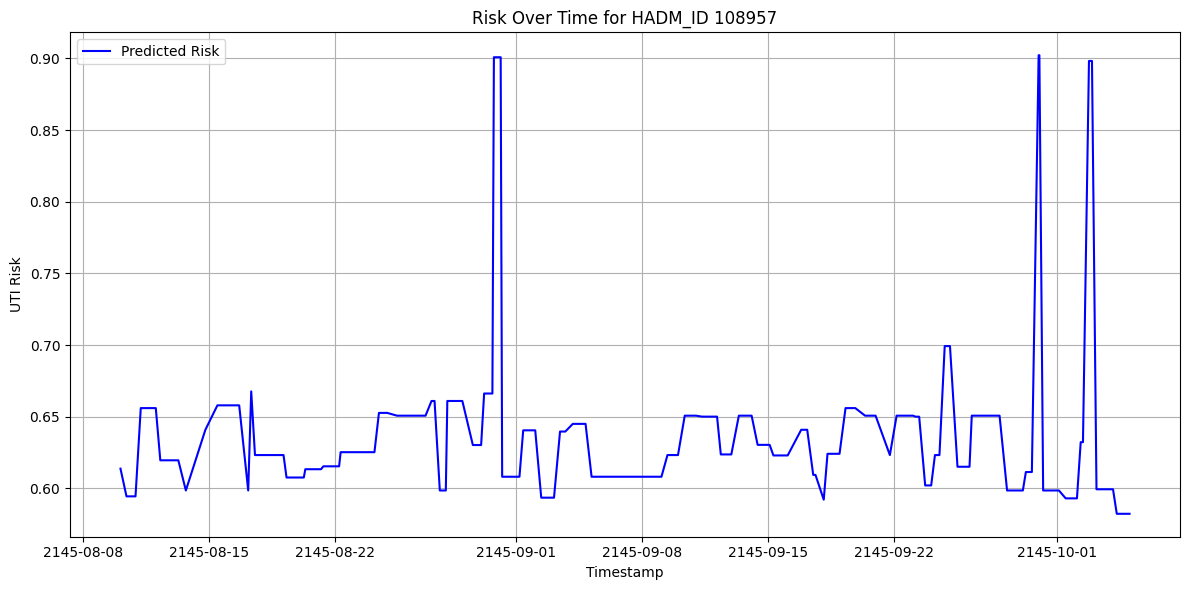

In [ ]:
# Plotting Risk Over Time for the chosen HADM_ID
sample_data = sample_data.sort_values(by="TIMESTAMP")
plt.figure(figsize=(12, 6))
plt.plot(sample_data["TIMESTAMP"], sample_data["Risk"], label='Predicted Risk', color='blue')
plt.title(f'Risk Over Time for HADM_ID {sample_HADM_ID}')
plt.xlabel('Timestamp')
plt.ylabel('UTI Risk')
#plt.ylim(0.5, 0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()